In [14]:
import numpy as np
import pyBigWig
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
sns.set_theme("paper", "whitegrid")

In [12]:
from scipy.signal import argrelextrema
from scipy.signal import correlate

# Clusters

In [44]:
fin = open("../data/Galaxy46-[plotHeatmap_on_data_13__sorted_filtered_regions].bed")

In [45]:
data = list(map(lambda x: x.split(), fin.readlines()))

In [46]:
data = np.array(data)

In [47]:
[round((data[1:, -1] == "cluster_" + str(i)).mean() * 100, 2) for i in range(1, 5)]

[29.5, 26.24, 25.25, 19.0]

In [48]:
26.24 + 25.25

51.489999999999995

In [51]:
data[1:]

array([['chr9', '122400000', '123320000', ..., '920000', '122399999',
        'cluster_1'],
       ['chr17', '31880000', '33360000', ..., '1480000', '31879997',
        'cluster_1'],
       ['chr16', '52120000', '54000000', ..., '1880000', '52119995',
        'cluster_1'],
       ...,
       ['chr10', '74640000', '75120000', ..., '480000', '74639993',
        'cluster_4'],
       ['chr15', '43240000', '43680000', ..., '440000', '43239996',
        'cluster_4'],
       ['chr2', '136320000', '136880000', ..., '560000', '136319999',
        'cluster_4']], dtype='<U25')

In [50]:
data

array([['#chrom', 'start', 'end', ..., 'blockSizes', 'blockStart',
        'deepTools_group'],
       ['chr9', '122400000', '123320000', ..., '920000', '122399999',
        'cluster_1'],
       ['chr17', '31880000', '33360000', ..., '1480000', '31879997',
        'cluster_1'],
       ...,
       ['chr10', '74640000', '75120000', ..., '480000', '74639993',
        'cluster_4'],
       ['chr15', '43240000', '43680000', ..., '440000', '43239996',
        'cluster_4'],
       ['chr2', '136320000', '136880000', ..., '560000', '136319999',
        'cluster_4']], dtype='<U25')

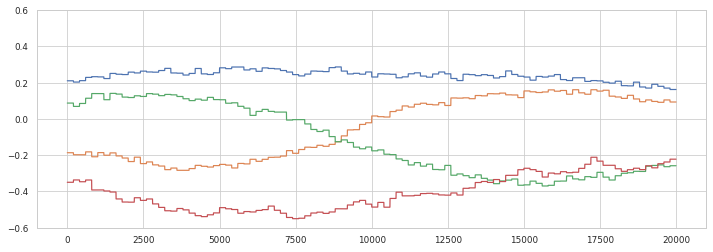

In [8]:
data = open("../data/input/profile.tabular")

data = list(map(lambda x: x.split(), data.readlines()))

data = np.array(data[2:])

clusters = [data[i, 2:].astype(float) for i in range(4)]

plt.figure(figsize=(12, 4))
plt.plot(data[0, 2:].astype(float))
plt.plot(data[1, 2:].astype(float))
plt.plot(data[2, 2:].astype(float))
plt.plot(data[3, 2:].astype(float))
plt.ylim(-0.6, 0.6)
plt.show()

In [9]:
averaged = pyBigWig.open(
    "../data/InformME/human colon normal METH NME ENTR MML VAR averaged/ENTR_averaged10000.bw"
)
tad_boundaries = list(map(lambda x: x.split(), open("../data/input/tad_boundaries_hESC_IMR90_hg19/h1.rep1.bed").readlines()))
tad_boundaries = np.array(tad_boundaries)

In [10]:
hard_filter = np.ones(50,)
hard_filter[:25] = -1
hard_filter /= 100

In [15]:
fin = dict()
RANGE = range(55, 105, 5)
for i in RANGE:
    fin[i] = pyBigWig.open(f"../data/output/entropy_blocks/{i}.bw", "w")
    fin[i].addHeader(list(averaged.chroms().items()))

for chr, chr_len in averaged.chroms().items():
    means = np.array(averaged.stats(chr, nBins=chr_len // 10000))
    means[means == None] = 0
    tad_boundaries_chr = tad_boundaries[tad_boundaries[:, 0] == chr]
    tad_boundaries_chr = tad_boundaries_chr[:, 1:].astype(int)
    responses = correlate(means, hard_filter)
    for order in tqdm(RANGE):
        predictions = sorted(np.concatenate(
            [argrelextrema(responses, comparator=np.greater, order=order)[0],
             argrelextrema(responses, comparator=np.less, order=order)[0]]) * 10000)
        values = np.ones(len(predictions) - 1).astype(float)
        values[::2] = -1.
        fin[order].addEntries([chr] * (len(predictions) - 1),
                              predictions[:-1],
                              predictions[1:],
                              values=values)                            

for i in RANGE:
    fin[i].close()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.65it/s]


In [16]:
# averaged = pyBigWig.open("human_informme_results_averaged/ENTR_averaged10000.bw")

# tad_boundaries = list(map(lambda x: x.split(), open("tad_boundaries_hESC_IMR90_hg19/h1.rep1.bed").readlines()))
# tad_boundaries = np.array(tad_boundaries)
chr = "chr1"
chr_len = averaged.chroms()[chr]
means = np.array(averaged.stats(chr, nBins=chr_len // 10000))
means[means == None] = 0
tad_boundaries_chr = tad_boundaries[tad_boundaries[:, 0] == chr]
tad_boundaries_chr = tad_boundaries_chr[:, 1:].astype(int)
responses = correlate(means, hard_filter)

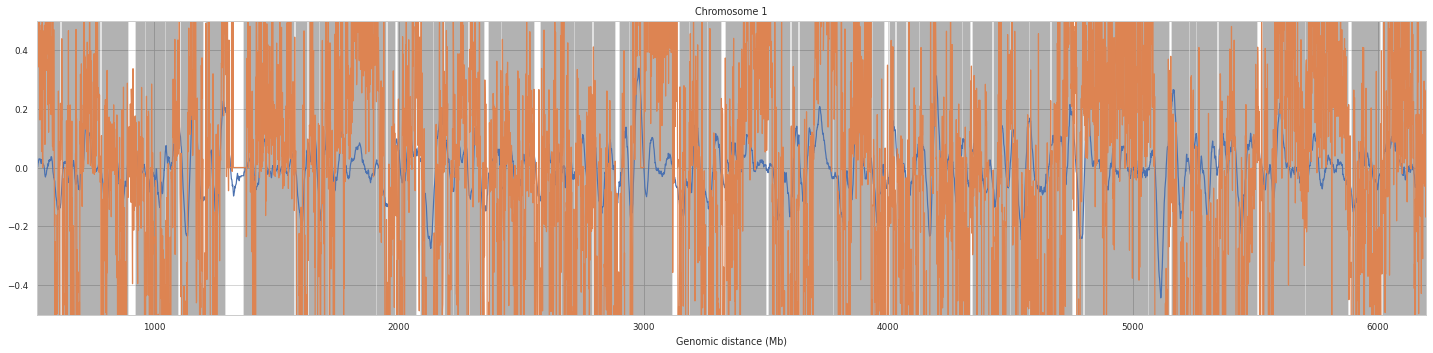

In [18]:
plt.figure(figsize=(20, 5))
plt.bar(tad_boundaries_chr[:, 0] // 10000, 1, (tad_boundaries_chr[:, 1] - tad_boundaries_chr[:, 0]) // 10000, bottom=-.5, align="edge", color="black", alpha=.3)
# plt.vlines(tad_boundaries_chr[:, 0] // 10000, -100, 100, linewidth=1)
# plt.plot(responses_first, label="disordered-ordered")
# plt.plot(responses_second, label="ordered-disordered")
plt.plot(responses)
# plt.vlines()
# plt.xlim(0, chr_len // 10000)
plt.xlim(52000000 // 100000, 62000000 // 10000)
plt.xlabel("Genomic distance (Mb)")
plt.ylim(-.5, .5)
# plt.xticks(np.arange(0, 25000, 5000), np.arange(0, 2500, 500))
plt.title("Chromosome 1")
plt.tight_layout()
# plt.savefig("figures/tads_and_responses.jpg")
plt.plot(means)

In [19]:
tad_sizes = tad_boundaries[:, 2].astype(int) - tad_boundaries[:, 1].astype(int)

In [22]:
thr = .1
predictions = np.concatenate([argrelextrema(responses, comparator=np.greater, order=46)[0],
                             argrelextrema(responses, comparator=np.less, order=46)[0]])

tad_boundaries_for_validation = tad_boundaries_chr.reshape(-1,) / 10000

errors = []
for prediction in predictions:
    errors.append(np.abs(prediction - tad_boundaries_for_validation).min() * 10000)


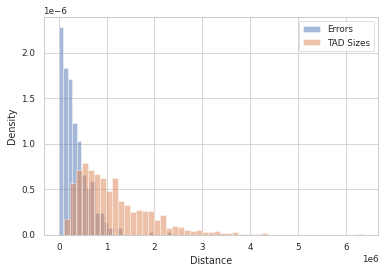

In [30]:
plt.hist(errors, bins=25, density=True, alpha=.5, label="Errors")
plt.hist(tad_sizes, bins=50, density=True, alpha=.5, label="TAD Sizes")
plt.ylabel("Density")
plt.xlabel("Distance")
plt.legend()
plt.show()

In [ ]:
# for chr_name in tqdm(entropy.chroms().keys()):
#     chr_len = entropy.chroms()[chr_name]
#     means = entropy.stats(chr_name, nBins=chr_len // window_size)
#     means = np.array(means)
#     starts = np.arange(0, chr_len - window_size, window_size)
#     starts = starts[means != None]
#     means = means[means != None]
#     averaged.addEntries(chr_name, starts, values=means.astype(float), span=window_size)
# averaged.close()